ERROR:root:File `'variables.ipynb.py'` not found.
ERROR:root:File `'utils.ipynb.py'` not found.
ERROR:root:File `'image_utils.ipynb.py'` not found.
ERROR:root:File `'global_variables.ipynb.py'` not found.


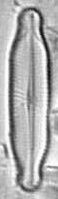

NameError: name 'split_img_list' is not defined

ERROR:root:File `'global_variables.ipynb.py'` not found.


NameError: name 'DATASETS' is not defined

ERROR:root:File `'../data_utils.ipynb.py'` not found.


In [1]:
from os import listdir
from os.path import isfile, join
import pickle
from IPython.display import clear_output
import PIL.Image
import multiprocessing
from lxml import etree
from sklearn.model_selection import train_test_split

%run ../utils_transform_dataset/generator.ipynb
%run ../variables.ipynb
%run ../utils.ipynb
%run ../data_utils.ipynb
%run ../global_variables.ipynb
%run ../image_utils.ipynb

TEST = None

In [6]:
#enregistre le code pour chaque taxon dans un fichier .pickle

def save_maps():
    images = []
    for path in DATASET_PATH:
        images.extend([f for f in listdir(path) if isfile(join(path, f))])

    tmp_code = {}
    i = 1
    for file in images:          #pour donner un identifiant à chaque taxon 
        taxon = file.split('_')[1]
        if not (taxon in tmp_code):
            tmp_code[taxon] = i  #i le code taxon mais on travaille en binaire  i={0,1}
            i+=1

    savePickle(tmp_code, os.path.join(SAVE_PATH, "maps/multiclass_label_map.pickle"))
    binary_tmp_code = {}
    binary_tmp_code["diatom"] = 1
    savePickle(binary_tmp_code, os.path.join(SAVE_PATH, "maps/binary_label_map.pickle"))
    print("Binary and multiclass label maps saved successfully !")

In [7]:
def worker(lock, n_id, wnumber, train, n_images, verbose, folder):
    # MAIN
    ref = cv2.imread(os.path.join(DATASETS_ROOT,"atlas/ref_img.png"), cv2.IMREAD_GRAYSCALE)
    diatom_images_train, diatom_images_val = split_img_list(list_images(DATASET_PATH, diatoms=True, ref=ref), PERCENTAGE_VAL)
    debris_images_train, debris_images_val = split_img_list(list_images(DATASET_DUST_PATH, diatoms=False, ref=ref), PERCENTAGE_VAL)
    if train:
        images=[diatom_images_train, debris_images_train]
    else:
        images=[diatom_images_val, debris_images_val]
    
    print("Worker ", wnumber, " ok!")
    np.random.seed(int(wnumber*1000))
    lock.acquire()
    wid = n_id.value
    if verbose:
        clear_output(wait=True)
        print("Worker ", wnumber, ": ", (wid+1),"/", n_images)
    n_id.value += 1
    lock.release()
    while(wid<=n_images):
        final_img, annotations = main_generator(images,
                                          simple_angles = False, 
                                          size_px = 1000,
                                          verbose=False, 
                                          overlapping=0.5, 
                                          n_diatoms=[9,12],
                                          scale_diatoms=[7,4.5],                                          
                                          n_dust=[25,40],
                                          scale_dust=[3,4])
        string_id = '{:05d}'.format(wid)
        final_img = final_img[:,:,1]
        
        # Init xml tree
        xml_root = etree.Element("annotation")
        etree.SubElement(xml_root, "folder").text = "images"
        etree.SubElement(xml_root, "filename").text = string_id+".png"
        source_xml = etree.SubElement(xml_root, "source")
        etree.SubElement(source_xml, "database").text = DATASET_NAME
        size_xml = etree.SubElement(xml_root, "size")
        etree.SubElement(size_xml, "width").text = str(final_img.shape[0])
        etree.SubElement(size_xml, "height").text = str(final_img.shape[1])
        etree.SubElement(size_xml, "depth").text = str(1)
        
        path_img = "images/"+string_id+".png"
        save_img(final_img, join(SAVE_PATH, folder, path_img));

        ## Saving individual masks
        taxon_n = {}
        paths = []
        for annotation in annotations:
            taxon = annotation["taxon"]
            if taxon in taxon_n:
                taxon_n[taxon] += 1
            else:
                taxon_n[taxon] = 0
            path_mask = "masks/"+string_id+"_"+taxon+"_"+'{:03d}'.format(taxon_n[taxon])+".png"
            # Saving mask
            #img = PIL.Image.fromarray(annotation["patch_mask"])
            annotation.pop("patch_mask")
            #output = io.BytesIO()
            check_dirs(join(SAVE_PATH, folder, path_mask))
            #img.save(join(SAVE_PATH, path_mask), format='PNG')
            annotation["mask_path"] = path_mask
            # Adding bounding box to xml
            object_xml = etree.SubElement(xml_root, "object")
            etree.SubElement(object_xml, "name").text = annotation["taxon"]
            bndbox_xml = etree.SubElement(object_xml, "bndbox")
            etree.SubElement(bndbox_xml, "xmin").text = str(annotation["xmin"])
            etree.SubElement(bndbox_xml, "ymin").text = str(annotation["ymin"])
            etree.SubElement(bndbox_xml, "xmax").text = str(annotation["xmax"])
            etree.SubElement(bndbox_xml, "ymax").text = str(annotation["ymax"])        
        
        # Saving annotation
        et = etree.ElementTree(xml_root)
        xml_path = os.path.join(SAVE_PATH, folder, "annotations/", string_id+".xml")
        check_dirs(xml_path)
        with open(xml_path, 'wb') as xml_file:
            et.write(xml_file, pretty_print=True)
        
        # Incrementing id
        lock.acquire()
        wid = n_id.value
        if verbose:
            clear_output(wait=True)
            print("Worker ", wnumber, ": ", (wid+1), "/", n_images)
        n_id.value += 1
        lock.release()
    return 0

In [ ]:
'''
# MAIN
ref = cv2.imread(os.path.join(DATASETS_ROOT,"atlas/ref_img.png"), cv2.IMREAD_GRAYSCALE)
diatom_images_train, diatom_images_val = split_img_list(list_images(DATASET_PATH, diatoms=True, ref=ref), PERCENTAGE_VAL)
debris_images_train, debris_images_val = split_img_list(list_images(DATASET_DUST_PATH, diatoms=False, ref=ref), PERCENTAGE_VAL)
print("Images loaded!")
'''

In [ ]:
jobs = []
n_process = 8
verbose = True
save_maps()

# Generating training set
folder = "train/"
n_images_train = (1-PERCENTAGE_VAL)*TOTAL_N_IMAGES
n_id_train = multiprocessing.Value('i', 0)
lock_train = multiprocessing.Lock()
print("Training: Generating", n_images_train, "images with ", n_process, " workers !")
for i in range(n_process):
    p = multiprocessing.Process(target=worker, args=(lock_train, 
                                                     n_id_train, 
                                                     i,
                                                     True,
                                                     n_images_train, 
                                                     verbose, 
                                                     folder))
    jobs.append(p)
    p.start()
# Wait for jobs to end
for job in jobs:
    job.join()
    
# Generating validation set
folder = "val/"
n_images_val = PERCENTAGE_VAL*TOTAL_N_IMAGES
n_id_val = multiprocessing.Value('i', 0)
lock_val = multiprocessing.Lock()
print("Validation: Generating", n_images_val, "images with ", n_process, " workers !")
for i in range(n_process):
    p = multiprocessing.Process(target=worker, args=(lock_val, 
                                                     n_id_val, 
                                                     i,
                                                     False,
                                                     n_images_val, 
                                                     verbose, 
                                                     folder))
    jobs.append(p)
    p.start()
for job in jobs:
    job.join()
print("Finished!")